<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>

# <font color="steelblue">Modelos de regresión para respuesta cualitativa dicotómica</font>

**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 01/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


## <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
# Cargamos módulos
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
import math             # importamos módulo para cáculos matemáticos

# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_50_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** En este cuaderno se realiza una aproximación a los modelos de regresión logística para variables respuesta de tipo cualitativo dicotómica. Se detallan todas las características de estos modelos y se presenta como obtenerlos utilizando la librería Scikit-Learn. Se introducen las primeras herramientas para la mejora del modelo de partida y todo ello se ejempifica sobre diferentes ejemplos simulados y reales.

**Nivel de Formación:** B

**Recomendaciones antes de usarlo:** Resulta de utilidad conocimientos básicos de estadística, así como haber cursado los cuadernos correspondientes a modelos de regresión con respuesta cauntitativa.



## <font color="steelblue">Objetivos de aprendizaje</font>

* Desarrollar modelos de regresión logística para respuestas de tipo dicotómico.
* Conocer las funciones necesarias para la obtención de modelos de regresión logística utilizando la librería Scikit-learn.
* Estudiar las diferentes métricas que valoran la capacidad predictiva de los modelos de regresión logística.
* Establecer estrategias que nos permitan estudiar la estabilidad de la solución planteada, así como el desarrollo de procedimientos de validación cruzada.
* Aplicar los modelos propuestos a diferentes ejemplos reales.

## <font color="steelblue">Contenidos</font>

1. ¿Qué son los modelos de regresión con respuesta cualitativa?
2. Modelo de regresión logística
  * El modelo
  * La tabla de clasificación
  * Estimación del modelo
  * Validación del modelo
3. Modelo de regresión logística con Scikit-Learn
  * Entrenamiento del modelo
  * Predicción
  * Métricas y validación del modelo
4. Aplicaciones
5. Referencias

# <font color="steelblue">¿Qué son los modelos de regresión con respuesta cualitativa?</font>

En los modelos de regresión que tratamos en este cuaderno la variable respuesta que queremos analizar sólo puede tomar dos valores posibles (0 o 1, Sí y No, Comprar o No comprar, etc...) de forma que el modelo de aprendizaje automático trata de predecir la probabilidad de que una muestra proporcione una respuesta específica entre las dos posibles en función de un conjunto de posibles variables predictoras (de tipo cuantitativo o cualitativo). De forma automática, una vez que determinamos la probabilidad de cada categoría tenemos disponible una herramienta de clasificación de las muestras en cada una de las dos categorías. Se trata pues de un método combinado entre un método de regresión y de clasificación. Estos modelos de aprendizaje  se denominan en la literatura modelos de clasificación binaria y el más conocido es la denominada regresión logística.

Dadas las características especiales de este tipo de modelos veremos que el análisis de la capacidad explicativa se basa en las métricas de clasificación y no de regresión.

Para mostrar el uso de estos modelos utilizaremos los conjuntos de datos `stroke` y `water potability` utilizados en cuadernos anteriores. Dado que en ambos casos ya hemos realizado el preprocesado de los datos, en este cuaderno nos centraremos en el análisis del modelo de regresión logística correspondiente.

# <font color="steelblue">Modelo de regresión logística</font>





A continuación se presentan brevemente los conceptos teóricos más relevantes de los modelos de regresión logística.

## <font color="steelblue">El modelo</font>

En este tipo de modelos disponemos de una variable respuesta ($y$) de tipo cualitativo con dos posibles respuestas que se codifican habitualmente con 0-1, donde el 0 indica "fracaso" y el 1 indica "éxito". Además, de una matriz de variables predictoras de tipo numérico y/o categórico, a partir de las cuales podemos obtener la matriz $X$. La definición de "éxito" o "fracaso" depende de cada problema específico.

Imaginemos que disponemos de $p$ posibles predictoras de forma que el conjunto de muestras viene dado por: 

$$\{(y_i, x_{1i},...x_{pi})\}_{i=1}^n$$

donde $x_{ji}$ es el valor de la muestra $i$ en la predictora $j$ e $y_i$ nos da el valor de la categoría de la muestra $i$ (codificada como 0 o 1). En esta situación construimos el predictor lineal:

$$z = w_0 + w_1X_1+...+w_pX_p$$

donde cada $w_j$ representa la pendiente o variación del predictor lineal con respecto a cada predictora, y $w_0$ representa el sesgo del modelo. Dado que el valor del predictor lineal no tiene por que estar restringido al intervalo $[0, 1]$ resulta necesario convertir dicho valor en una probabilidad para determinar la solución del modelo. Para realizar esta operación utilizamos la función logística:

$$\phi(z) = \frac{1}{1+e^{-z}},$$

que permite pasar cualquier valor del intervalo $[-∞,∞]$ al intervalo $[0,1]$, es decir, pasamos cualquier valor numérico a una probabilidad. En la figura siguiente podemos ver la representación gráfica de la función logística para diferentes valores de z:

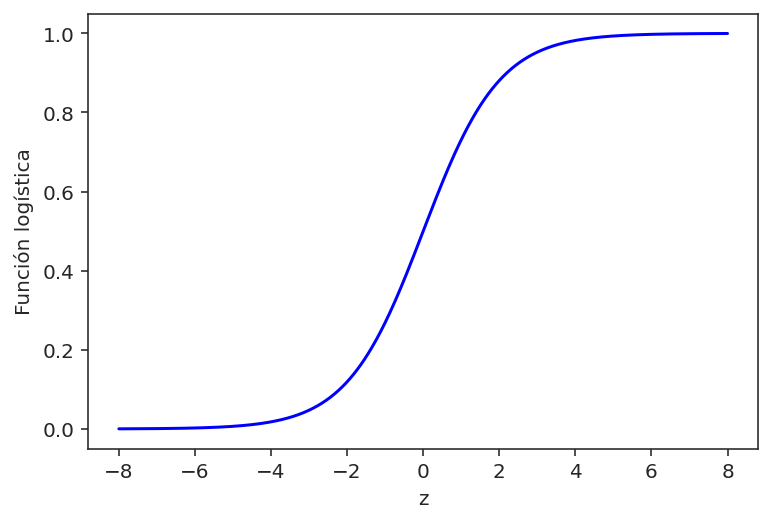

In [ ]:
# Gráfico de la función logistica

from math import exp
# Valores
z = np.linspace(-8,8,1000)
y = np.zeros(len(z))
for i in range(1000):
  y[i] = 1/(1+exp(-z[i]))
# Gráfico
plt.plot(z, y, "b-")
plt.xlabel('z')
plt.ylabel('Función logística')
plt.show()

La función logit se define entonces como:

$$logit(P(y=1 | X) = z,$$

donde $P(y=1 | X)$ es la probabilidad condicional de que una muestra concreta pertenezca a la clase 1 dadas sus predictoras $X$. La función logit toma entradas en el rango $[0, 1]$ y las transforma en valores en todo el rango de números reales. En cambio, la función logística toma valores de entrada en todo el rango de números reales y los transforma en valores en el rango $[0, 1]$. En otras palabras, la función logística es la inversa de la función logit, y nos permite predecir la probabilidad condicional de que una determinada muestra pertenezca a la clase 1 (o a la clase 0). En realidad a partir de ambas expresiones podemos escribir:

$$P(y=1 | X) = \frac{e^{w_0 + w_1X_1+...+w_pX_p}}{1+e^{w_0 + w_1X_1+...+w_pX_p}}$$

y podemos relacionar las probabilidades condicionadas de ambas respuestas mediante el log-odds:

$$log(\frac{P(y=1 | X)}{P(y=0 | X)}) = w_0 + w_1X_1+...+w_pX_p$$

que podemos utilizar para representar el ratio entre la probabilidad de evento verdadero y la probabilidad de evento falso (odds ratio):

$$\frac{P(y=1 | X)}{P(y=0 | X)} = exp(w_0 + w_1X_1+...+w_pX_p)$$

Los principales elementos que hay que interpretar en un modelo de regresión logística son los siguientes coeficientes de los predictores:

* $w_0$  es la ordenada en el origen o intercept. Se corresponde con el valor esperado del logaritmo de odds cuando todos los predictores son cero. 

* $w_p$ son los coeficientes de regresión parcial de cada predictor e indican el cambio promedio del logaritmo de odds al incrementar en una unidad la variable predictora, manteniéndose constantes el resto de variables. Esto equivale a decir que, por cada unidad que se incrementa la predictora, se multiplican los odds por  $e^{w_p}$.

Dado que la relación entre  la probabilidad condicional y las predictoras no es lineal, los coeficientes de regresión  no se corresponden con el cambio en la probabilidad de  la respuesta  asociada con el incremento en una unidad de la predictora, sino con el cambio en el log-odds.

Como ocurría en los modelos lineales, la magnitud de cada coeficiente parcial de regresión depende de las unidades en las que se mida la variable predictora a la que corresponde, por lo que su magnitud no está asociada con la importancia de cada predictor. Para poder determinar qué impacto tienen en el modelo cada una de las variables, se emplean los coeficientes parciales estandarizados, que se obtienen al estandarizar las predictoras.

## <font color="steelblue">La tabla de clasificación</font>

Una de las principales aplicaciones de un modelo de regresión logística es clasificar la variable cualitativa en función del valor que tomen los predictores. Dado que la salida de un modelo logístico es una probabilidad, para conseguir la clasificación, es necesario establecer un límite (threshold) a partir del cual se considera que la variable pertenece a uno de los niveles. Por ejemplo, se puede asignar una observación al grupo 1 si la probabilidad estimada es mayor de 0.5 y al grupo 0 en caso contrario.

## <font color="steelblue">Estimación del modelo</font>

Para obtener los parámetros de regresión logística debemos establecer la función de pérdida que debemos minimizar. En este caso se define:

$$J(w) = \sum_{i=1}^n [-y_ilog(\phi(z_i) - (1-y_i)log(1-\phi(z_i)].$$

Dicha función se corresponde con menos el logaritmo de la función de versosimilitud $-log(L(w) = -l(w)$.

Para la minimización de $J(w)$ podemos utilizar diferentes estrategias pero la más habitual es el gradiente descendiente cuyo proceso de actualización a partir de una solución inicial para $w$ y del ratio de aprendizaje $\eta$ viene dado por:

$$w_j := w_j + \eta \sum_{i=1}^n (y_i - \phi(z_i))x_{ij}$$

## <font color="steelblue">Validación del modelo</font>

Para el análisis de validación o capacidad explicativa del modelo utilizamos la matriz de confusión que obtenemos al comparar los valores reales observados para la respuesta y los valores predichos por el modelo, es decir, una vez conseguidos los parámetros $w$ obtenemos la clasificación del modelo a partir de las probabilidades estimadas. Podemos utilizar entonces todas las métricas para modelos de clasificación para valorar la capacidad del modelo.

En el punto siguiente mostramos todas las posibilidades de validación que se encuentran disponibles en las librerías `scikit-learn` y `mlxtend`.

# <font color="steelblue">Modelo de regresión logística con Scikit-Learn</font>

En este apartado se presentan las funciones principales para la construcción y evaluación de los modelos de regresión logísica. Se han establecido tres apartados: entrenamiento del modelo, predicción, y métricas/validación del modelo.

## <font color="steelblue">Entrenamiento del modelo</font>

Para la implementación de modelos de regresión logística utilizamos la función [LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression) de la clase `sklearn.linear_model`. 

Los parámatros básicos para la configuración de esta función son:

* **penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’**, que establece el tipo de regularización de los parámetros del modelo.  

* **solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’**, que identifica el algoritmo utilizado para la estimación de los parámetros del modelo. Para resolver el problema de estimación hay que tener en cuenta los siguientes aspectos: 

 * Para conjuntos de datos pequeños, 'liblinear' es una buena opción, mientras que 'sag' y 'saga' son más rápidos para los grandes;

  * Para problemas multiclase, solo 'newton-cg', 'sag', 'saga' y 'lbfgs' manejan pérdidas multinomiales;

De hecho la elección del algoritmo depende de la penalización elegida. Las penalizaciones soportadas para cada algoritmo son:
  * '`newton-cg`' - ['l2', 'none']
  * '`lbfgs`' - ['l2', 'none']
  * '`liblinear`' - ['l1', 'l2']
  * '`sag`' - ['l2', 'none']
  * '`saga`' - ['elasticnet', 'l1', 'l2', 'none']

El resultado de esta función es un objeto de la clase modelos lineales que tiene asociados diferentes métodos. A continuación, vemos el código para crear el ajuste y presentamos los diferentes métodos.

In [ ]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression()

El primer método es el que nos permite realizar el entrenamiento del modelo `fit` donde debemos especificar la matriz de predictoras y la respuesta:

```
modelo.fit(X, y)
```

Podemos obtener los nombres de las predictoras utilizadas con el método `get_params()`

```
modelo.get_params()
```

y los parámetros del modelo (interceptación y pendientes) con las funciones:

```
modelo.intercept_
modelo.coef_
```

Para obtener los odds ratio asociados a cada uno de los coeficientes del modelo se aplica la función exponencial sobre los valores proporcionados por el método anterior.

## <font color="steelblue">Predicción</font>


Para la predicción en este tipo de modelos tenemos tres formas distintas: predecir el valor de clasificación de cada muestra, predecir la probabilidad de cada clase de la respuesta para una muestra dada, y el logaritmo de las probabilidades anteriores. 

Para obtener los valores predichos para la muestra de validación (`X_test`) o de entrenamiento (`X_train`), es decir, si la muestra es clasificada como 0 o 1 a partir del modelo entrenado se usa el método `predict`:

```
modelo.predict(X)
```

Podemos obtener las probabilidades de clasificación de cada clase para cada uno de los elementos de la muestra con:

```
modelo.predict_proba(X)
```

y el logaritmo de dichas probabilidades con

```
modelo.predict_log_proba(X)
```

## <font color="steelblue">Métricas y validación del modelo</font>

Todas las métricas y medidas de validez del modelo de regresión logística se basan en la obtención de la matriz de confusión asociada, que es la matriz que nos contabiliza aciertos y fallos entre los valores observados en la muestra de validación y los valores predichos por el modelo. 

Todas la métricas que vamos a utilizar se encuentran dentro de la clase `sklearn.metrics`. Las más utilizadas son: 

* `confusion_matrix`, que nos permite obtener la matriz de confusión y `plot_confusion_matrix` que nos permite representarla gráficamente.
* `clasification_report`, que nos permite obtener un informe con las métricas habituales para problemas de clasificación (exactitud, precisión, recuerdo y f1), tanto a nivel individual para cada clase de la respuesta como en términos globales.
* `roc_curve`, que nos permite extraer la curva ROC asociada a nuestro modelo. Las curvas ROC se utilizan a menudo para obtener una visión del resultado de un clasificador en términos de sus verdaderos frente a los falsos positivos. Suelen presentar la tasa de verdaderos positivos en el eje Y, y la tasa de falsos positivos en el eje X. Por tanto, la inclinación de la curva y el espacio entre la diagonal y la curva son importantes ya que cuanto más alejada esté la curva y más hacia arriba mejor será nuestro modelo. 
* `roc_auc_score`, que permite obtener el área bajo la curva ROC, de forma que valores próximos a 1 indican un buen ajuste mientras que valores próximos a 0.5 indican un ajuste malo.

Dentro de las medidas de validez del modelo utilizaremos como en el caso de los modelos lineales los procesos de validación cruzada y de la curva de aprendizaje. Veremos como utilizar estas funciones dierectamente sobre los ejemplos presentados.

Cargamos todas estas funciones

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay 
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV 

# <font color="steelblue">Aplicaciones</font>

A continuación presentamos los diferentes bancos de datos con los que ilustraremos el uso de los modelos de regresión logística. 

* Stroke
* Water potability


In [ ]:
# Stroke Prediction Dataset 
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/stroke_ori.csv'
stroke = pd.read_csv(url)
# Water potability
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/water_potability.csv'
water = pd.read_csv(url)

Funciones para el preprocesado de datos

In [ ]:
# Cargamos todos los módulos y funciones
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 

## <font color="steelblue">Stroke</font>

Como ya vimos en el cuaderno correspondiente el banco de datos `Stroke`  se utiliza para predecir si un paciente tiene más o menos probabilidad de sufrir un ictus, en función de su género, edad, enfermedades y estatus de fumador. Cada fila en los datos proporciona información relevante sobre cada uno de los pacientes. Las variables predictoras son `gender`, `age`, `hypertension`, `heart_disease`, `ever_married`, `work_type`, `Residence_type`, `avg_glucose_level`, `bmi`, `smoking_status`, mientras que la variable respuesta, que en este caso es categórica, es `stroke` con valores Yes y No.

### <font color="steelblue">Preparación de los datos</font>

En este caso identificamos los tipos de las variables y asignamos los adecuados, realizamos las tareas de preprocesamiento y división de muestras.

In [ ]:
# Tipos
stroke.dtypes

id                     int64
gender                object
age                  float64
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                object
dtype: object

Asignación de tipos de variables

In [ ]:
# Seleccionamos variables numéricas para estandarización 
str_num_var = stroke.select_dtypes(include=['float64']).columns.values
# Seleccionamos categóricas para codificación, excluyendo id y stroke
str_cat_var = stroke.select_dtypes(include=['object']).columns.values[1:7]
print(str_num_var)
print(str_cat_var)
# Separamos los datos según variables numéricas y categóricas
stroke_num_var = stroke[str_num_var]
stroke_cat_var = stroke[str_cat_var]

['age' 'avg_glucose_level' 'bmi']
['hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'smoking_status']


En primer lugar preprocesamos las variables numéricas (imputación y estandarización) y luego las categóricas (imputación y codificación). Utilizamos pipeline para realizar las tareas en una única función.

In [ ]:
# Inicializamos el Pipeline numéricas
num_var_pipe = Pipeline([
                  ('imputer', SimpleImputer(strategy='median')), # Imputación
                  ('scaler', StandardScaler()) # Estandarización        
            ])
# Lo aplicamos a las variables numéricas
num_var_preprocessed = num_var_pipe.fit_transform(stroke_num_var)

Trabajamos ahora con las categóricas. En este caso sólo realizamos la codificación habitual.

In [ ]:
# Pipeline categóricas
cat_var_pipe = Pipeline([
     ('encoder', OneHotEncoder(drop='first'))                      
])
# Resultado del preprocesado
cat_var_preprocessed = cat_var_pipe.fit_transform(stroke_cat_var)

Combinamos ambos preprocesados para obtener la base de datos final. Como ya comentamos en cuadernos anteriores, en las variables categóricas por defecto no aparecen los nombres de las nuevas variables. Resulta necesario extraerlos e integrarlos todos en un dataframe para la correcta implementación de los modelos de aprendizaje automático. Estos nombres de las variables se pueden extraer de los pipeline establecidos. A continuación se muestra el código necesario.

In [ ]:
# Lista de variables por tipo
num_list = list(stroke_num_var)
cat_list = list(stroke_cat_var)
# Pipeline conjunto a partir de los pipeline individuales
final_pipe = ColumnTransformer([
   ('num', num_var_pipe, num_list),    
   ('cat', cat_var_pipe, cat_list)                        
])
# Obtenemos el array de datos preprocesados
data_preprocessed = final_pipe.fit_transform(stroke)

In [ ]:
# Pasos del pipeline
clf = Pipeline(steps=[('preprocessor', final_pipe)])
# Extraemos los nombres utilizando como raíz el nombre de la variable original y como sufijo la etiqueta correspondiente
names_cat = clf.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_list)
# Nombres de las variables
names = np.concatenate((str_num_var, names_cat), axis = None)
# Dataframe completo de datos con variables predictoras
stroke_prepro = pd.DataFrame(data_preprocessed, columns = names)
# Se añade la variable respuesta u objetivo
stroke_prepro['stroke'] = stroke['stroke']

Identificamos con una variable 0-1 la respuesta.

In [ ]:
# resultado del proceso
stroke_prepro.head()

,age,avg_glucose_level,bmi,hypertension_Yes,heart_disease_Yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,1.051434,2.706375,1.005086,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Yes
1,0.786070,2.121559,-0.098981,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Yes
2,1.626390,-0.005028,0.472536,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes
3,0.255342,1.437358,0.719327,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Yes
4,1.582163,1.501184,-0.631531,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Yes


In [ ]:
# Obtener dummies
stroke_prepro['stroke_code'] = pd.get_dummies(stroke_prepro['stroke'], drop_first = True)
stroke_prepro.head()

,age,avg_glucose_level,bmi,hypertension_Yes,heart_disease_Yes,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke,stroke_code
0,1.051434,2.706375,1.005086,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Yes,1
1,0.786070,2.121559,-0.098981,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Yes,1
2,1.626390,-0.005028,0.472536,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes,1
3,0.255342,1.437358,0.719327,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Yes,1
4,1.582163,1.501184,-0.631531,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Yes,1


In [ ]:
# Asignamos
y1 = stroke_prepro['stroke_code']
X1= stroke_prepro.drop(columns = ['stroke','stroke_code'])

Una vez hemos realizado el preprocesado dividimos las bases de datos en conjuntos de entrenamiento y validación. Utilizamos la muestra de entrenamiento de los datos preprocesados para el entrenamiento del modelo y los datos originales para el análisis descriptivo inicial. Tomamos un 70% de muestras para los datos de entrenamiento y el 30% restante para la validación.

In [ ]:
from sklearn.model_selection import train_test_split
# División de muestras normalizadas
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=0)

## <font color="steelblue">Water</font>

El banco de datos `water` tiene por objetivo estudiar la potabilidad del agua utilizando varias propiedades químicas. Las variables predictoras que lo componen son: `pH`, `Hardness`, `Solids`, `Chloramines`, `Sulfate`, `Conductivity`, `Organic_carbon`, `Trihalomethanes`, `Turbidity` y la variable respuesta es `Potability`.

### <font color="steelblue">Preparación de los datos</font>

Identificación y selección de tipos:

In [ ]:
# Tipos
water.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

Convertimos la respuesta a categórica ya que el resto son numéricas.

In [ ]:
# Reconversión
water['Potability'] = water['Potability'].astype("category")
# Seleccionamos variables numéricas para estandarización 
wat_num_var = water.select_dtypes(include=['float64']).columns.values
print(wat_num_var)
# Separamos los datos según variables numéricas y categóricas
water_num_var = water[wat_num_var]

['ph' 'Hardness' 'Solids' 'Chloramines' 'Sulfate' 'Conductivity'
 'Organic_carbon' 'Trihalomethanes' 'Turbidity']


Dado que sólo tenemos variables numéricas el preprocesado se centra en la imputación y estandarización.

In [ ]:
# Inicializamos el Pipeline
num_var_pipe = Pipeline([
                  ('imputer', SimpleImputer(strategy='median')), # Imputación
                  ('scaler', StandardScaler())  # Estandarización
            ])
# Lo aplicamos a las variables numéricas
water_preprocessed = num_var_pipe.fit_transform(water_num_var)

Asignamos los nombres a las variables.

In [ ]:
# Nombres de las variables
names = water.columns.values
# Dataframe completo de datos
water_imputer = pd.DataFrame(water_preprocessed, columns = names[0:9])

In [ ]:
# Asignamos respuesta y predictoras
y2 = water['Potability']
# matriz de características
X2 = water_imputer

Realizamos la divisón de muestras en entrenamiento y validación.

In [ ]:
# División de muestras normalizadas
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=0)

# <font color="steelblue">Nuestros modelos</font>




Para comenzar vamos a utilizar la penalización por defecto de la función `LogisticRegression` que en este caso es la `l2`. Estudiaremos además la capacidad explicativa de dichos modelos con las métricas habituales cuando la variable respuesta es de tipo categórico. Finalizaremos utilizando procedimientos de validación cruzada para mejorar el ajuste.


## <font color="steelblue">Stroke</font>

### Entrenamiento

Realizamos el proceso de entrenamiento del modelo con la configuración sin penalizaciones. Obtenemos la precisión de la muestra de entrenamiento y los coeficientes del modelo (y odds ratio asociados). Utilizamos el optimizador saga ya que es compatible con cualquier penalización sobre los coeficientes.

In [ ]:
# Configuración del modelo
m1 = LogisticRegression(solver = 'saga', max_iter=500)
# Ajuste
m1.fit(X = X1_train, y = y1_train)
# Coeficientes del modelo
m1_coef = list(zip(X1.columns, m1.coef_.flatten(), ))
# Precisión del entrenamiento del modelo
m1_acc = m1.score(X1_train, y1_train)

# Información del modelo
# ==============================================================================
print("Exactitud de entrenamiento:", m1_acc)

Exactitud de entrenamiento: 0.9516354487000279


La precisión obtenida nos indica que el modelo planteado es capaz de predecir la probabilidad de sufrir un ictus con bastante exactitud. Analizamos ahora los coeficientes del modelo. Añadimos los odds asociados.

In [ ]:
# Coeficientes del modelo
dfcoef = pd.DataFrame(list(zip(X1.columns, m1.coef_.flatten(), )),
             columns=['Variable','coeficiente']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef['odds'] = round(np.exp(dfcoef['coeficiente']),3)
dfcoef

,coeficiente,odds
Variable,,
age,1.746177,5.733
avg_glucose_level,0.157423,1.170
bmi,0.024722,1.025
hypertension_Yes,0.301477,1.352
heart_disease_Yes,0.509596,1.665
ever_married_Yes,-0.410915,0.663
work_type_Never_worked,-0.030076,0.970
work_type_Private,0.242757,1.275
work_type_Self-employed,-0.218952,0.803


Las variables que más influencia tienen de manera positiva (aumentan la probabilidad de sufrir un ictus) en el modelo son la edad(`age`), tener una enfermedad cardíaca (`heart_disease_Yes`) y tener hipertensión (`hypertension_Yes`). Por otro lado, las que más influyen de manera negativa (disminuyen la probabilidad de sufrir un ictus) son haberse casado (`ever_married_Yes`), ser un niño (`work_type_children`) y ser autónomo (`work_type_Self-employed`).

### Predicción y métricas de evaluación



Obtenemos las predicciones para la muestra de validación y su precisión. Obtenemos también la matriz de confusión y realizamos el análisis de curvas ROC.

In [ ]:
# Predicciones
predictions = m1.predict(X1_test)
# Precisión para la muestra de validación
accuracy_score(y1_test, predictions)

0.9504240052185258

La exactitud obtenida para la muestra de validación es similar a la de la muestra de entrenamiento. Obtenemos ahora la matriz de confusión para estudiar el proceso de clasificación. En concreto utilizamos la representación gráfica de dicha matriz. Utilizamos la función `ConfusionMatrixDisplay` en lugar de `plot_confusion_matrix` que está a punto de desaparecer.

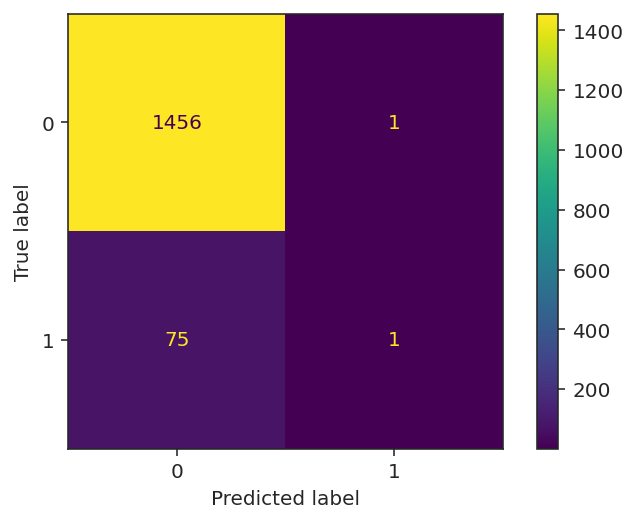

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y1_test, predictions, labels = m1.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m1.classes_)
# Representamos
disp.plot();

En la tabla de clasificación podemos ver como hay 1457 muestras clasificadas correctamente frente a 76 que no lo están. Aunque la predicción obtenida es bastante buena tenemos un problema para predecir de forma adecuada las muestras que originalmente habían sufrido un ictus, ya que sólo clasificamos correctamente 1 de las 76 muestras consideradas. 

Para finalizar realizamos el análisis de las curvas ROC. En primer lugar obtenemos las probabilidades vinculadas al modelo entrenado lo que nos premitirá obtener la curva ROC así como calcular el AUC score.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


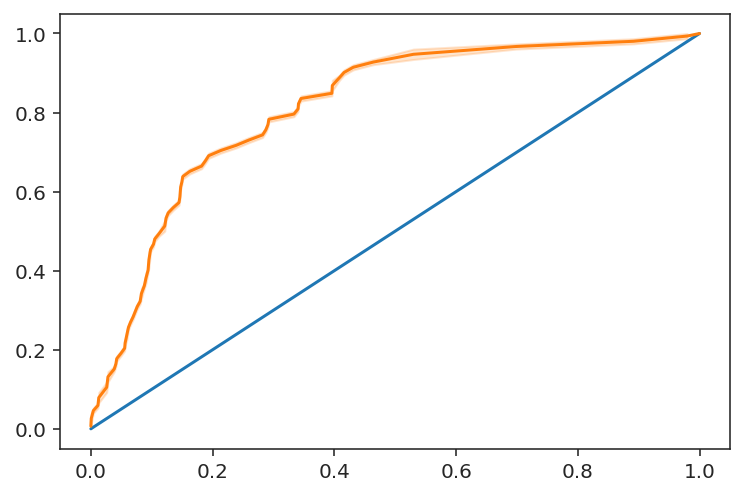

In [ ]:
# Obtenemos probabilidades
y1_probs = m1.predict_proba(X1_test)
# Calculamos y representamos curva ROC
fpr, tpr, thresholds = roc_curve(y1_test, y1_probs[:,1]);
sns.lineplot([0, 1], [0, 1]);
sns.lineplot(fpr, tpr);

El comportamiento de la curva ROC indica (como era de esperar) que el modelo obtenido resulta útil para predecir el comportamiento de la probabilidad de sufrir un ictus en función de las predictoras consideradas.

Calculamos el área bajo la curva:

In [ ]:
round(roc_auc_score(y1_test,y1_probs[:,1]),3)

0.813

El valor obtenido cerca de 1 indica que el modelo propuesto es bastante adecuado.

### Validación cruzada y curva de aprendizaje

Realizamos ahora un estudio de validación cruzada para conocer la estabilidad de la solución conseguida con el modelo de regresión logística.

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(m1, X1_train, y1_train, cv=10, scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.951915,0.002575,0.94958,0.949721,0.952381,0.952514,0.958101


Hay una gran estabilidad de la solución en torno a una exactitud del 0.95 ya que la desviación estándar se sitúa en 0.002. Analizamos también el área bajo la curva ROC. 

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(m1, X1_train, y1_train, cv=10, scoring ='roc_auc'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.847904,0.035191,0.795848,0.82131,0.846559,0.87804,0.897712


De nuevo la solución es muy estable ya que la desviación estándar es muy pequeña. El AUC estimado se sitúa en 0.85.

Analizamos ahora la curva de aprendizaje conforme variamos el tamaño de la muestra de entrenamiento y validación.

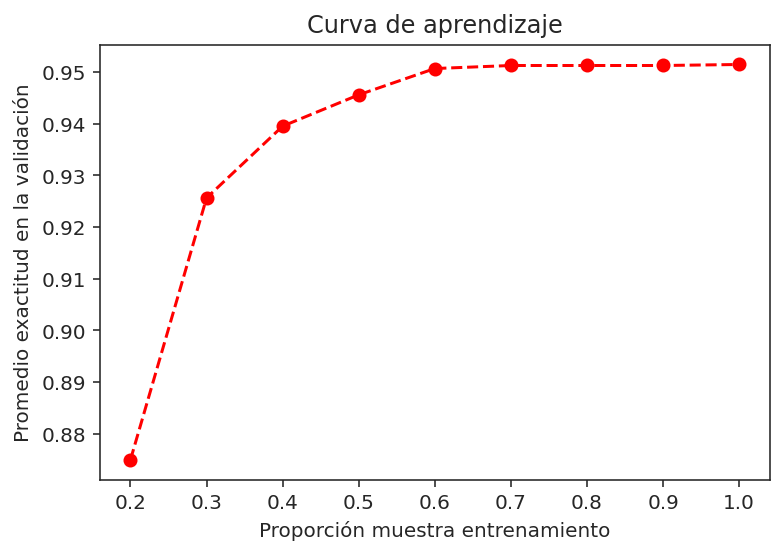

In [ ]:
#Fijamos tamaños de muestra de entrenamiento
size = np.linspace(0.2, 1, 9)
# Evalaumos la precisión para los diferentes tamaños
train_sizes, train_scores, test_scores = learning_curve(
    m1, X1, y1, train_sizes=size, scoring="accuracy", cv=10)
# Representamos gráficamente
plt.plot(size, test_scores.mean(1), "o--", color="r", label="RLog-validación")
plt.xlabel("Proporción muestra entrenamiento")
plt.ylabel("Promedio exactitud en la validación")
plt.title("Curva de aprendizaje")
plt.show()

Se aprecia como la precisión es estable a partir del 60% de la muestra de entrenamiento. Se puede ver que incluso con un 30% de muestra de entrenamiento la precisión del modelo supera el 90%.

### Regularización

Exploramos las diferentes posibilidades del algoritmo de ajuste de la regresión logística en cuanto a la regularización de los coeficientes del modelo estimado. Recordemos que la solución por defecto se corresponde con la regularización L2 o "rigde". Veamos que ocurre con la solución "lasso" o "elasticnet". Ajustamos ambos modelos, analizamos la precisión asociada y valoramos los coeficientes de cada uno de los modelos. En este caso tomamos un optimizador que permita trabajar con cualquier penalización (`solver = "saga"`)

In [ ]:
# Configuración del modelo
m1_1 = LogisticRegression(penalty='l1', solver = 'saga', max_iter=500)
m1_2 = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio=0.5, max_iter=500)
# Ajuste
m1_1.fit(X = X1_train, y = y1_train)
m1_2.fit(X = X1_train, y = y1_train)
# Coeficientes del modelo
m1_1_coef = list(zip(X1.columns, m1_1.coef_.flatten(), ))
m1_2_coef = list(zip(X1.columns, m1_2.coef_.flatten(), ))
# Precisión del entrenamiento del modelo
m1_1_acc = m1_1.score(X1_train, y1_train)
m1_2_acc = m1_2.score(X1_train, y1_train)

# Información del modelo
# ==============================================================================
print("Exactitud de entrenamiento:", m1_1_acc)
print("Exactitud de entrenamiento:", m1_2_acc)

Exactitud de entrenamiento: 0.9513558848196813
Exactitud de entrenamiento: 0.9516354487000279


Las exactitudes de ambos modelos se corresponden con la obtenida con el modelo por defecto (penalización `l2`). Estudiamos ahora los coeficientes de ambos modelos.

In [ ]:
# Coeficientes del modelo l1
dfcoef_1 = pd.DataFrame(list(zip(X1.columns, m1_1.coef_.flatten(), )),
             columns=['Variable','Coef L1']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef_1['odds'] = round(np.exp(dfcoef_1['Coef L1']),3)

# Coeficientes del modelo elasticnet
dfcoef_2 = pd.DataFrame(list(zip(X1.columns, m1_2.coef_.flatten(), )),
             columns=['Variable','Coef elasticnet']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef_2['odds'] = round(np.exp(dfcoef_2['Coef elasticnet']),3)

### Concatenamos los resultados de los tres modelos
pd.concat([dfcoef, dfcoef_1, dfcoef_2], axis=1)

,coeficiente,odds,Coef L1,odds,Coef elasticnet,odds
Variable,,,,,,
age,1.746177,5.733,1.769135,5.866,1.762171,5.825
avg_glucose_level,0.157423,1.170,0.155944,1.169,0.156623,1.170
bmi,0.024722,1.025,0.020684,1.021,0.023937,1.024
hypertension_Yes,0.301477,1.352,0.269847,1.310,0.285213,1.330
heart_disease_Yes,0.509596,1.665,0.482576,1.620,0.495419,1.641
ever_married_Yes,-0.410915,0.663,-0.373616,0.688,-0.390243,0.677
work_type_Never_worked,-0.030076,0.970,0.000000,1.000,0.000000,1.000
work_type_Private,0.242757,1.275,0.242792,1.275,0.246179,1.279
work_type_Self-employed,-0.218952,0.803,-0.195452,0.822,-0.204930,0.815


Los tres modelos proporcionan casi la misma solución salvo por los coeficientes que son cero en las dos últimas penalizaciones. Parece lógico plantear un análisis de selección de variables para tratar de obtener el mejor modelo posible.

### Selección de predictoras via regularización

Como hemos visto en el punto anterior los métodos de regularicación `l1` y `elasticnet` nos permiten identificar las predictoras que no resultan relevantes para explicar el comportamiento de la respuesta. En concreto usamos la regularización `l1` con diferentes grados de penalización para determinar que predictoras son relevantes y cuales no. A la vista de los resultados procedemos a evalaur el nuevo modelo y comparar su capacidad explicativa con el modelo propuesto originalmente. Aumentamos el número de iteraciones para prevenir problemas de convergencia, ya que al usar diferentes grados de penalización podemos tener problemas.

In [ ]:
# Especificamos el modelo
model = LogisticRegression(penalty='l1', solver = 'saga', max_iter=4000)
# Probamos diferentes valores del grado de penalización
searcher = GridSearchCV(model, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X1_train, y1_train)
# Valores óptimos
print("Valor óptimo de C", searcher.best_params_)

Valor óptimo de C {'C': 1}


En este caso la solución óptima se corresponde con la solución por defecto para la penaliación `l1` que obtuvimos antes. Las predictoras no relevantes en ese caso son: `work_type_Never_worked`, `work_type_children`, `smoking_status_formerly smoked`, `smoking_status_smokes`. Podemos ver además que los indicadores que más influyen (en términos de odds ratio) sobre la probabilidad de tener un ictus son (ordenados de más a menos): `age`, `heart_disease_Yes`, y `hypertension_Yes`. Por otro lado, los indicadores que más influyen en la probabildiad de no sufir un ictus son: `ever_married_Yes`, `work_type_Self-employed`, y `smoking_status_never smoked`.

## <font color="steelblue">Water</font>

Analizamos ahora la base de datos de potabilidad del agua.

### Entrenamiento

In [ ]:
# Configuración del modelo
m2 = LogisticRegression(solver = 'saga', max_iter=500)
# Ajuste
m2.fit(X = X2_train, y = y2_train)
# Coeficientes del modelo
m2_coef = list(zip(X2.columns, m2.coef_.flatten(), ))
# Precisión del entrenamiento del modelo
m2_acc = m2.score(X2_train, y2_train)

# Información del modelo
# ==============================================================================
print("Precisión de entrenamiento:", m2_acc)

Precisión de entrenamiento: 0.6070649803750545


El modelo no ajusta especialmente bien ya que la precisión es de 0.61. Analizamos ahora los coeficientes del modelo. Añadimos los odds asociados.

In [ ]:
# Coeficientes del modelo
dfcoef = pd.DataFrame(list(zip(X2.columns, m2.coef_.flatten(), )),
             columns=['Variable','coeficiente']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef['odds'] = round(np.exp(dfcoef['coeficiente']),3)
dfcoef

,coeficiente,odds
Variable,,
ph,0.016290,1.016
Hardness,-0.035160,0.965
Solids,0.091945,1.096
Chloramines,0.042010,1.043
Sulfate,-0.044720,0.956
Conductivity,-0.012647,0.987
Organic_carbon,-0.028797,0.972
Trihalomethanes,-0.017733,0.982
Turbidity,0.019871,1.020


En este modelo, las variables que más influyen en el estado de potabilidad del agua son `Solids`, `Chloramines` y `Sulfate`.

### Predicción y métricas de evaluación

Obtenemos las predicciones para la muestra de validación y su precisión. Obtenemos también la matriz de confusión y realizamos el análisis de curvas ROC.

In [ ]:
# Predicciones
predictions2 = m2.predict(X2_test)
# Precisión para la muestra de validación
accuracy_score(y2_test, predictions2)

0.6225839267548321

La exactitud obtenida para la muestra de validación es similar a la de la muestra de entrenamiento. Obtenemos ahora la matriz de confusión para estudiar el proceso de clasificación. 

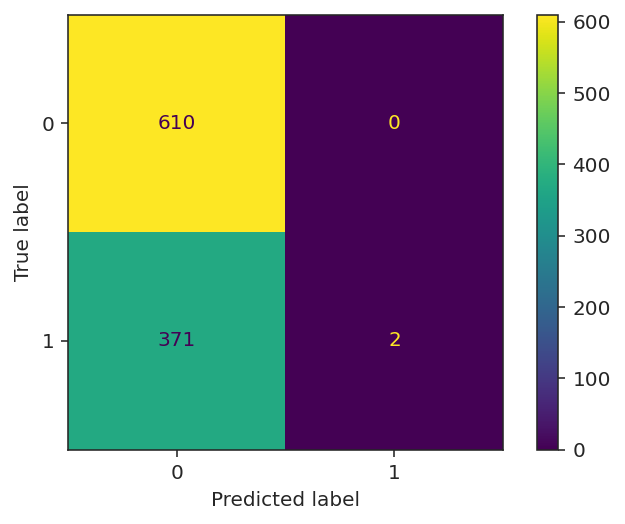

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y2_test, predictions2, labels = m2.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m2.classes_)
# Representamos
disp.plot();

En la tabla de clasificación podemos ver como hay 612 muestras clasificadas correctamente frente a 371 que no lo están. Aunque la predicción obtenida es bastante buena tenemos un problema para predecir de forma adecuada las muestras que originalmente se han clasificado como potables, ya que sólo clasificamos correctamente 2 de las 373 muestras consideradas. 

Para finalizar realizamos el análisis de las curvas ROC. En primer lugar obtenemos las probabilidades vinculadas al modelo entrenado lo que nos permitirá obtener la curva ROC así como calcular el AUC score.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


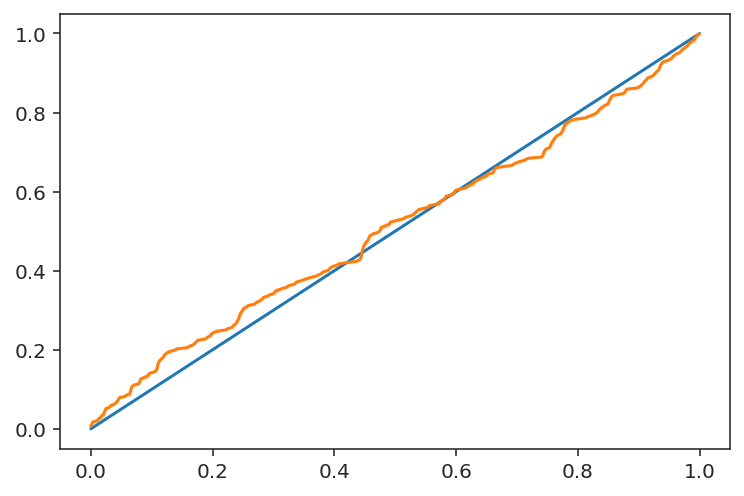

In [ ]:
# Obtenemos probabilidades
y2_probs = m2.predict_proba(X2_test)
# Calculamos y representamos curva ROC
fpr, tpr, thresholds = roc_curve(y2_test, y2_probs[:,1]);
sns.lineplot([0, 1], [0, 1]);
sns.lineplot(fpr, tpr);

El comportamiento de la curva ROC indica (como era de esperar) que el modelo obtenido resulta poco útil para predecir el comportamiento de la probabilidiad de clasificar el agua como potable. Calculamos el área bajo la curva:

In [ ]:
round(roc_auc_score(y2_test,y2_probs[:,1]),3)

0.509

El área bajo la curva está muy próxima a 0.5 indicando poca capacidad explicativa de las predictoras para explicar el comportamiento de la respuesta, es decir, para estimar la clasificación del agua como potable y no potable.

### Validación cruzada y curva de aprendizaje

Realizamos ahora una estudio de validación cruzada para conocer la estabilidad de la solución conseguida con el modelo de regresión logística.

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(m2, X2_train, y2_train, cv=10, scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.606193,0.004491,0.6,0.60262,0.605667,0.610262,0.613043


Hay una gran estabilidad de la solución en torno a una exactitud del 0.61 ya que la desviación estándar se sitúa en 0.005. Analizamos también el área bajo la curva ROC. Se puede ver como la calidad del modelo no es excesivamente buena.

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(m2, X2_train, y2_train, cv=10, scoring ='roc_auc'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.486675,0.028232,0.442565,0.46287,0.496644,0.509725,0.5172


De nuevo la solución es muy estable ya que la desviación estándar es muy pequeña. El AUC estimado se sitúa en 0.49. Dado el valor tan próximo a 0.5 la solución obtenida no es muy buena.

Analizamos ahora la curva de aprendizaje conforme variamos el tamaño de la muestra de entrenamiento y validación.

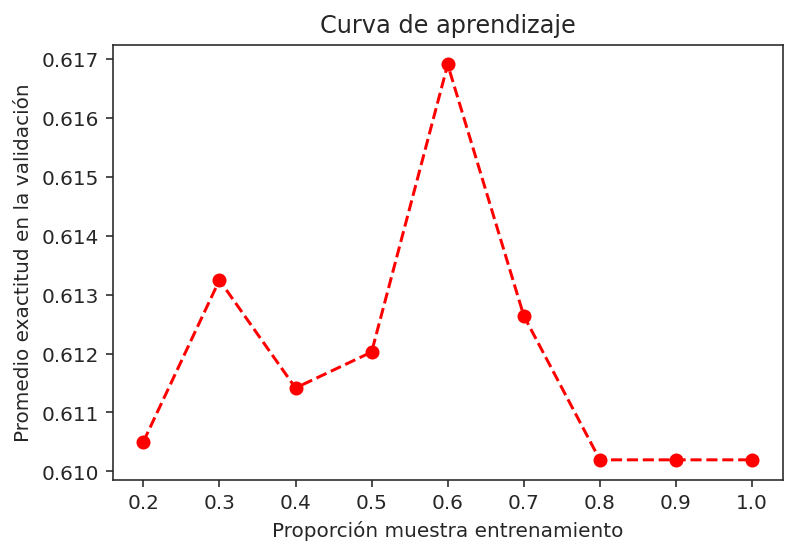

In [ ]:
#Fijamos tamaños de muestra de entranmiento
size = np.linspace(0.2, 1, 9)
# Evañaumos la precisión para los diferentes tamaños
train_sizes, train_scores, test_scores = learning_curve(
    m2, X2, y2, train_sizes=size, scoring="accuracy", cv=10)
# Representamos gráficamente
plt.plot(size, test_scores.mean(1), "o--", color="r", label="RLog-validación")
plt.xlabel("Proporción muestra entrenamiento")
plt.ylabel("Promedio exactitud en la validación")
plt.title("Curva de aprendizaje")
plt.show()

Se aprecia como la exactitud es estable en torno a 0.61 independientemente del tamaño de la muestra de entrenamiento ya que las pequeñas variaciones observadas no son relevantes para el cambio en el promedio de la precisión de la validación.

### Regularización

Como en el ejemplo anterior planteamos dos modelos penalizados como alternativa al obtenido por defecto.

In [ ]:
# Configuración del modelo
m2_1 = LogisticRegression(penalty='l1', solver = 'saga', max_iter=500)
m2_2 = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio=0.5, max_iter=500)
# Ajuste
m2_1.fit(X = X2_train, y = y2_train)
m2_2.fit(X = X2_train, y = y2_train)
# Coeficientes del modelo
m2_1_coef = list(zip(X2.columns, m2_1.coef_.flatten(), ))
m2_2_coef = list(zip(X2.columns, m2_2.coef_.flatten(), ))
# Precisión del entrenamiento del modelo
m2_1_acc = m2_1.score(X2_train, y2_train)
m2_2_acc = m2_2.score(X2_train, y2_train)

# Información del modelo
# ==============================================================================
print("Exactitud de entrenamiento:", m2_1_acc)
print("Exactitud de entrenamiento:", m2_2_acc)

Exactitud de entrenamiento: 0.6066288704753597
Exactitud de entrenamiento: 0.6070649803750545


Ambas exactitudes son muy similares y parecidas al modelo por defecto. Veamos las tablas de coeficientes.

In [ ]:
# Coeficientes del modelo por defecto
dfcoef = pd.DataFrame(list(zip(X2.columns, m2.coef_.flatten(), )),
             columns=['Variable','coeficiente']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef['odds'] = round(np.exp(dfcoef['coeficiente']),3)

# Coeficientes del modelo l1
dfcoef_1 = pd.DataFrame(list(zip(X2.columns, m2_1.coef_.flatten(), )),
             columns=['Variable','Coef L1']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef_1['odds'] = round(np.exp(dfcoef_1['Coef L1']),3)

# Coeficientes del modelo elasticnet
dfcoef_2 = pd.DataFrame(list(zip(X2.columns, m2_2.coef_.flatten(), )),
             columns=['Variable','Coef elasticnet']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef_2['odds'] = round(np.exp(dfcoef_2['Coef elasticnet']),3)

### Concatenamos los resultados de los tres modelos
pd.concat([dfcoef, dfcoef_1, dfcoef_2], axis=1)

,coeficiente,odds,Coef L1,odds,Coef elasticnet,odds
Variable,,,,,,
ph,0.016290,1.016,0.013872,1.014,0.015086,1.015
Hardness,-0.035160,0.965,-0.033035,0.968,-0.034099,0.966
Solids,0.091945,1.096,0.090275,1.094,0.091109,1.095
Chloramines,0.042010,1.043,0.040076,1.041,0.041045,1.042
Sulfate,-0.044720,0.956,-0.043002,0.958,-0.043858,0.957
Conductivity,-0.012647,0.987,-0.010775,0.989,-0.011717,0.988
Organic_carbon,-0.028797,0.972,-0.027092,0.973,-0.027948,0.972
Trihalomethanes,-0.017733,0.982,-0.015826,0.984,-0.016781,0.983
Turbidity,0.019871,1.020,0.018072,1.018,0.018972,1.019


En todos los modelos los coeficientes del modelo son similares. La penalización considerada no afecta a la estimación del modelo final.

### Selección de predictoras via regularización

Procedemos como en el ejemplo anterior para tratar de determinar las predictoras no relevantes a partir de la penalización `l1`.

In [ ]:
# Especificamos el modelo
model = LogisticRegression(penalty='l1', solver = 'saga', max_iter=4000)
# Probamos diferentes valores del grado de penalización
searcher = GridSearchCV(model, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X2_train, y2_train)
# Valores óptimos
print("Valor óptimo de C", searcher.best_params_)

Valor óptimo de C {'C': 10}


Procedemos a ajustar el nuevo modelo con `C=10`.

In [ ]:
# Configuración del modelo
m2 = LogisticRegression(C=10, penalty='l1', solver = 'saga', max_iter=4000)
# Ajuste
m2.fit(X = X2_train, y = y2_train)
# Coeficientes del modelo
m2_coef = list(zip(X2.columns, m2.coef_.flatten(), ))
# Precisión del entrenamiento del modelo
m2_acc = m2.score(X2_train, y2_train)

# Información del modelo
# ==============================================================================
print("Exactitud de entrenamiento:", m2_acc)

Exactitud de entrenamiento: 0.6070649803750545


El valor de la exactitud es similar al del modelo original. Pasamos a estudiar los coeficientes del modelo

In [ ]:
# Coeficientes del modelo
dfcoef = pd.DataFrame(list(zip(X2.columns, m2.coef_.flatten(), )),
             columns=['Variable','coeficiente']).set_index("Variable")
# Odds ratio asociado a cada predictora
dfcoef['odds'] = round(np.exp(dfcoef['coeficiente']),3)
dfcoef

,coeficiente,odds
Variable,,
ph,0.016104,1.016
Hardness,-0.035014,0.966
Solids,0.091929,1.096
Chloramines,0.041899,1.043
Sulfate,-0.044599,0.956
Conductivity,-0.012483,0.988
Organic_carbon,-0.028671,0.972
Trihalomethanes,-0.017573,0.983
Turbidity,0.019719,1.020


En principio no hay ningún predictor con un odds ratio de cero, pero como se puede ver todos están muy próximos a 1 reflejando el poco poder explicativo de este modelo.

# <font color="steelblue">Referencias y enlaces de interés</font>





Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

* Raschka, Sebastian (2018) MLxtend: Providing machine learning and data science utilities and extensions to Python's scientific computing stack. J Open Source Softw 3(24).

Enlaces

* Microsoft: https://github.com/microsoft/ML-For-Beginners/tree/main/2-Regression/4-Logistic

* Scikit-Learn. Logistic regression: https://scikit-learn.org/stable/modules/linear_model.html?highlight=logistic#logistic-regression

* Nyandwi, J.D. Mahine Learning Complete. Linear Models for Classification: https://github.com/Nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/2_linear_models_for_classification.ipynb

* Amat, J. (2020). https://www.cienciadedatos.net/documentos/py17-regresion-logistica-python.html